In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools


np.random.seed(42)

path = r'C:\Users\User\Documents\Training Assignments\ConvNet'
train_name = 'mnist_train.csv'
test_name = 'mnist_test.csv'


training_data = pd.read_csv(os.path.join(path, train_name), sep = ',',header=None)
testing_data = pd.read_csv(os.path.join(path,test_name),sep = ',', header=None)

####Split the training set into training and validation sets
train_data = training_data.sample(frac=0.9, random_state = 42)
val_data = training_data.drop(train_data.index, axis = 0)


In [73]:
### separate out the output from the input arrays for training, validation and testing sets
train_y = train_data.iloc[:,0].values.reshape(-1,1)
train_x = train_data.drop(0,axis=1).values.reshape(len(train_data),28,28)

val_y = val_data.iloc[:,0].values.reshape(-1,1)
val_x = val_data.drop(0,axis=1).values.reshape(len(val_data),28,28)

test_y = testing_data.iloc[:,0].values.reshape(-1,1)
test_x = testing_data.drop(0,axis=1).values.reshape(len(testing_data),28,28)

In [74]:
#### Define Batch Size
X_sample = train_x[:8]
Y_sample = train_y[:8]

In [75]:
### Convert output Y into One Hot Vectors
def output_one_hot(Y):    
    output_list=[]
    for value in Y:
        output = np.zeros((10,1))
        output[value] = value
        output_list.append(output)
        continue
    return np.asarray(output_list)

    
Y_sample = output_one_hot(Y_sample)

In [76]:
#### Define activation functions- Have used only ReLU and Softmax in the code

def ReLU(Z):
    return np.maximum(0,Z)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def softmax_loss(soft_max,Y):
    #cross entropy loss
    return -1*np.sum(Y*np.log(soft_max))


def softmax(X): 
    X -= np.max(X) #ensure that gradients don't explode
    return  np.exp(X)/np.sum(np.exp(X),axis=0)      

In [77]:
#### convolution operation for forward pass
def cross_correlation(X, kernel, pad_width, stride, kernel_bias):
    
    row_id = kernel.shape[0] ## vertical length of filter
    col_id = kernel.shape[1] ## horizontal length of filter
    activation_map = []
    
    ### get the shape of the output activation_map
    n_out_rows = (X.shape[0] + 2*pad_width - row_id)/stride + 1 
    n_out_cols = (X.shape[1] + 2*pad_width - col_id)/stride + 1
    
    ###pad if option is provided
    X = np.pad(X,(pad_width, pad_width),'constant', constant_values = (0))
    
   #### take slices of the input image and then multilpy with filter. Add bias = kernel_bias as well. 
    # the y index should be in the range 0 to the vertical length with step length = stride 
    for stride_y in range(0, X.shape[0], stride): 
        if stride_y + row_id <= X.shape[0]:
            ##the x index should be in the range 0 to the horizontal length with step length = stride
            for stride_x in range(0, X.shape[1], stride):
                if stride_x + col_id <= X.shape[1]:
                    activation_map.append(np.sum(X[stride_y:stride_y+row_id, stride_x:stride_x+col_id]*kernel)+\
                                          float(kernel_bias))
                    continue        
            continue
    
    ##reshape activation map into appropriate shape
    activation_map = np.asarray(activation_map).reshape(n_out_rows, n_out_cols)
    
    return activation_map    
    

In [78]:
### max pooling operation
def max_pooling(X, kernel, stride,pad_width = 0):
    row_id = kernel.shape[0] ## vertical length of the filter
    col_id = kernel.shape[1] ### horizontal length of the filter 
    pooling_map = []
    max_indexes = []

    ### compute output shape after pooling    
    n_out_rows = (X.shape[0] + 2*pad_width - row_id)/stride + 1
    n_out_cols = (X.shape[1] + 2*pad_width - col_id)/stride + 1
    
    
    for stride_y in range(0, X.shape[0], stride):
        for stride_x in range(0, X.shape[1], stride):
            if stride_y + row_id <= X.shape[0]:
                if stride_x + col_id <= X.shape[1]:
                    pooling_map.append(np.amax(X[stride_y:stride_y+row_id, stride_x:stride_x+col_id]))
                    ###take a small slice and flatten it. Then find the argument of the max value from that so that\
                    ### if multiple entries are present in a slice then only one index is returned.
                    temp = X[stride_y:stride_y+row_id, stride_x:stride_x+col_id]
                    temp.ravel()
                    max_id = np.argmax(temp, axis=0)
                    max_indexes.append(max_id)
                                    
    ### reshape pooled activation_map into computed shape
    pooling_map = np.asarray(pooling_map).reshape(n_out_rows, n_out_cols)    

    return pooling_map, max_indexes    

In [79]:
###FORWARD PASS
def forward_pass_fc(X,Y, theta_2, bias_2, theta_1, bias_1):
    np.random.seed(42)
  
    #### FULLY CONNECTED LAYER-1 RelU Activation (input from pooling, output to FC2)
    fc1_input = X.ravel().reshape(-1,1)
    fc1_output = ReLU(np.matmul(theta_1.T, fc1_input) + bias_1)

    ####FULLY CONNECTED LAYER-2 SOFTMAX layer (input from FC-1, output to Loss function)
    fc2_output = softmax(np.matmul(theta_2.T, fc1_output) + bias_2)
    #loss = softmax_loss(fc2_output,Y_sample)
    
    return fc2_output, fc1_output

In [80]:
####BACKWARD PASS
def backpropagation_fc(X, Y, X_sample, theta_2, bias_2, theta_1, bias_1, max_indexes, activation_map,kernel, stride):
    
    ### Call forward pass
    a2, a1 = forward_pass_fc(X, Y, theta_2, bias_2, theta_1, bias_1)
    

    ####LOSS function backprop
    d_a2 = np.reciprocal(a2)
    d_z2 = np.zeros(a2.shape).ravel()
    

    ####SOFTMAX backprop- FULLY CONNECTED LAYER-2
    for i in range(len(a2)):
        for j in range(len(a2)):
            if i==j:
                d_z2[i] = a2[i]*(1-a2[i])
            else:
                d_z2[i] = -1*a2[i]*a2[j]
    
    d_z2 = d_z2.reshape(-1,1)
    d_theta_2 = d_z2*a1.T
    d_bias_2 = d_z2
    
   
    ####FULLY CONNECTED LAYER-1 ACTIVATION RelU Backprop 
    d_z1 = a1.copy()
    d_z1[d_z1 <= 0] = 0
    d_z1[d_z1 > 0 ] = 1

    d_theta_1 = d_z1*X.ravel().reshape(-1,1).T
    d_bias_1 = d_z1

        
    ###GRADIENT OF Flattened output from pooling layer. Input to FC-1
    d_flattened_X = np.dot(d_theta_1.T, d_z1)
    

    #### reshaped into shape of pooling output
    d_flattened_X = d_flattened_X.reshape(X.shape)
    

    ### Flattened X broadcast into shape of output from convolution
    d_reshaped_X = d_flattened_X.repeat(2,axis=0).repeat(2,axis=1)
    
    
    ##### Backprop for MAX POOLING Backprop
    
    ##create an array of zeros of shape activation map = output from convolution 
    grad_pooling = np.zeros_like(activation_map)
    
    ## insert ones at locations of max value
    for i in max_indexes:
        grad_pooling[i] = 1.0

      
    ### Gradient of MAX POOLING 
    d_pooling = d_reshaped_X*grad_pooling
    
        
    #####CONVOLUTION ACTIVATION ReLU Backprop
    grad_activation_map = d_pooling.copy()
    
    grad_activation_map[grad_activation_map <= 0] = 0
    grad_activation_map[grad_activation_map > 0 ] = 1
    
    
    #####Convolution backprop
    row_id = kernel.shape[0] ##vertical length of filter used in convolution
    col_id = kernel.shape[1] ##horizontal length of filter used in convolution
    

    ### initialize gradient of kernel with shape of kernel
    d_kernel = np.zeros_like(kernel)
    
    #### take slices of shape = kernel from the input image and from gradient of the convolution operation. \
    ###Multiply element-wise to get gradient of loss with respect to kernel
    for stride_y in range(0, grad_activation_map.shape[0], stride):
        for stride_x in range(0, grad_activation_map.shape[1], stride):
            if stride_y + row_id <= grad_activation_map.shape[0]:
                if stride_x + col_id <= grad_activation_map.shape[1]:
                    temp = X_sample[stride_y:stride_y+row_id, stride_x:stride_x+col_id]*\
                    grad_activation_map[stride_y:stride_y+row_id, stride_x:stride_x+col_id]
                    d_kernel = d_kernel + temp
                    del temp

    ### compute Gradient of bias used in convolution operation                    
    d_kernel_bias = grad_activation_map.ravel().sum()
    
    return d_z2, d_theta_2, d_bias_2, d_z1, d_theta_1, d_bias_1, d_kernel, d_kernel_bias

In [81]:
#### Function to run the entire neural network
def run(X, Y, alpha, num_of_iterations):
    np.random.seed(42)

    ### initialize the kernel used in convolution
    kernel = np.random.randn(3,3)
    
    
    ### intialize the kernel used in max pooling operation
    kernel_pool = np.zeros((2,2))
    
    
    #### initialize the bias used in convolution operation
    kernel_bias = float(np.random.randn(1))
    
    ### initialize the weights of FC-1
    theta_1 = np.random.randn(196, 5)
    bias_1 = np.random.randn(5,1)

    ### initialize the weights of FC-2
    theta_2 = np.random.randn(5, 10)
    bias_2 = np.random.randn(10,1)



    training_loss=[]
    ### no of epochs
    for iter_num in range(num_of_iterations):
    
        ###for each sample in batch
        for X_sample, Y_sample in itertools.izip(X, Y):

            ### call convolution operation forward pass
            activation_map = cross_correlation(X_sample, kernel, 1, 1, kernel_bias)
    
            ### call max pooling operation forward pass
            fc1_input, max_indexes = max_pooling(activation_map, kernel_pool, 2)
        
            ### call the forward pass for FC layers
            a2, a1  = forward_pass_fc(fc1_input,Y_sample, theta_2, bias_2, theta_1, bias_1)

            ### call the backpropagation operations
            d_z2, d_theta_2, d_bias_2, d_z1, d_theta_1, d_bias_1, d_kernel, d_kernel_bias = \
            backpropagation_fc(fc1_input,Y_sample,X_sample, theta_2, bias_2, theta_1, bias_1,max_indexes, activation_map,kernel,1)

            ### calculate the loss 
            loss = softmax_loss(softmax(a2), Y_sample)
            training_loss.append(loss)
        
            ### compute alpha/num of training samples and call it modified alpha
            mod_alpha = float(alpha)/float(batch_size)
                        
            ### simulataneous parameter update
            kernel = kernel - mod_alpha*d_kernel
            kernel_bias = kernel_bias - mod_alpha*d_kernel_bias
            theta_1 = theta_1 - mod_alpha*d_theta_1.T
            bias_1 = bias_1 - mod_alpha*d_bias_1
            theta_2 = theta_2 - mod_alpha*d_theta_2.T
            bias_2 = bias_2 - mod_alpha*d_bias_2
        
            print 'loss', loss
            
    return training_loss 

In [82]:
alpha = 0.003
num_of_iterations = 100
batch_size = len(X_sample)
training_loss = run(X_sample, Y_sample, alpha, num_of_iterations)

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in reciprocal
  if __name__ == '__main__':


loss 17.228051202141327
loss 7.383450515203425
loss 18.678722549629754
loss 21.365603230303886
loss 7.383450515203425
loss 21.36560692947449
loss 17.228051202141327
loss 16.21435135813903
loss 16.214351669222438
loss 6.503260362875205
loss 18.678725082013752
loss 21.36562542397652
loss 6.503257540325697
loss 21.36563282114693
loss 16.214353535735157
loss 16.214353846822657
loss 16.214354157910744
loss 6.5032528363379996
loss 18.678728458450358
loss 21.36565501049711
loss 6.503250014102257
loss 21.365662406226914
loss 16.21435602445151
loss 16.214356335543684
loss 16.214356646636435
loss 6.503245310637437
loss 18.67873183480077
loss 21.365684591255885
loss 6.503242488715383
loss 21.36569198554549
loss 16.214358513205216
loss 16.21435882430205
loss 16.21435913539947
loss 6.503237785773324
loss 18.67873521106496
loss 21.365714166254488
loss 6.503234964164891
loss 21.36572155910431
loss 16.214361001996206
loss 16.2143613130977
loss 16.214361624199775
loss 6.503230261745474
loss 18.67873858

loss 6.502929984218982
loss 18.67887356328466
loss 21.366921802027473
loss 6.502927175408638
loss 21.36692913620031
loss 16.214463073817843
loss 16.214463385104047
loss 16.214463696390798
loss 6.502922494316981
loss 18.678876935900178
loss 21.366951136584852
loss 6.50291968581732
loss 21.36695846933513
loss 16.214465564122737
loss 16.214465875413296
loss 16.214466186704403
loss 6.502915005243412
loss 18.678880308428173
loss 21.36698046545262
loss 6.502912197054364
loss 21.36698779678075
loss 16.214468054462447
loss 16.214468365757355
loss 16.214468677052803
loss 6.502907516998087
loss 18.678883680868623
loss 21.36700978863241
loss 6.5029047091195835
loss 21.367017118538797
loss 16.214470544836907
loss 16.214470856136153
loss 16.214471167435946
loss 6.502900029580822
loss 18.678887053221494
loss 21.367039106125837
loss 6.502897222012793
loss 21.36704643461089
loss 16.214473035246066
loss 16.214473346549642
loss 16.214473657853766
loss 6.502892542991432
loss 18.678890425486763
loss 21.36

loss 16.214570499129387
loss 16.214570810596946
loss 6.502601209781554
loss 18.67902187518687
loss 21.368207161650787
loss 6.502598414575861
loss 21.368214433614103
loss 16.214572679412967
loss 16.214572990884076
loss 16.214573302355692
loss 6.502593756156092
loss 18.679025243923906
loss 21.368236247396737
loss 6.502590961258047
loss 21.368243517955257
loss 16.214575171195992
loss 16.214575482671144
loss 16.214575794146803
loss 6.5025863033509665
loss 18.67902861257214
loss 21.368265327524107
loss 6.502583508760503
loss 21.36827259667823
loss 16.214577663011347
loss 16.21457797449054
loss 16.214578285970234
loss 6.502578851365998
loss 18.67903198113155
loss 21.368294402034497
loss 6.502576057083045
loss 21.36830166978463
loss 16.21458015485898
loss 16.2145804663422
loss 16.214580777825923
loss 6.5025714002010035
loss 18.6790353496021
loss 21.368323470929504
loss 6.502568606225493
loss 21.368330737276043
loss 16.21458264673883
loss 16.214582958226075
loss 16.21458326971382
loss 6.502563

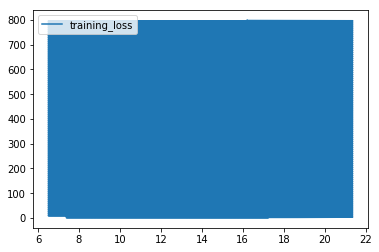

In [83]:
### plot the training losses 
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss, range(batch_size*num_of_iterations),label='training_loss')
plt.legend()
plt.show()


In [87]:
### ALT OPERATIONS CODE

#for index in np.ndindex(X.shape):
                    #    if X[index] == np.amax(X[stride_y:stride_y+row_id, stride_x:stride_x+col_id]):
                    #        if index not in index_list:
                    #            index_list.append(index)
                    #3#3            temp_list.append([X[index],index])
                    #            break
                    #3        else:
                    #3            print X[index], index
                    #        continue    
                    
                    
                                        
                    #for row in range(stride_y,stride_y+row_id):
                    #    l=1
                    #    print 'row',row
                    #    for col in range(stride_x,stride_x+col_id):
                    #        print 'col',col
                    #        if X[row,col] == np.amax(X[row:row+row_id, col:col+col_id]):
                    #            index_list.append((row,col))
                    #            l=0
                    #            break
                    #    if l == 0:
                    #        break
                    
                    
                    
                                        #for index in np.ndindex(X.shape):
                    #    if X[index] == np.amax(X[stride_y:stride_y+row_id, stride_x:stride_x+col_id]):
                    #        if index[1] < stride_x + col_id:
                    #            if index[0] < stride_y + row_id:
                    #                index_list.append([X[index],index])
                    #                continue

                    
                                        #temp1 = np.equal(X,\
                                    # np.amax(X[stride_y:stride_y+row_id, stride_x:stride_x+col_id]))
                    #print '%d \n' %(stride_y), temp1
                    
                    #temp = np.argmax(temp1==True)
                    
                    
#for num in range(len(X_sample)):
#for i, j in itertools.izip(X_sample,Y_sample):
#    print i
#    break

#import numpy as np#

#stride = 1

#X_sample = np.array([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]])
#grad_activation_map = np.array([[2,2,2,2,2],[4,4,4,4,4],[6,6,6,6,6],[8,8,8,8,8],[10,10,10,10,10]])
#kernel = np.zeros((3,3))
#d_kernel = kernel.copy()
#row_id = kernel.shape[0]
#col_id = kernel.shape[1]

#for stride_y in range(0, grad_activation_map.shape[0], stride):
#        for stride_x in range(0, grad_activation_map.shape[1], stride):
#            if stride_y + row_id <= grad_activation_map.shape[0]:
#                if stride_x + col_id <= grad_activation_map.shape[1]:
#                    temp = X_sample[stride_y:stride_y+row_id, stride_x:stride_x+col_id]*\
#                    grad_activation_map[stride_y:stride_y+row_id, stride_x:stride_x+col_id]
#                    d_kernel = d_kernel + temp
#                    #print '\ntemp',temp, '\n'
#                    del temp
                    #print 'd_kernel \n', d_kernel

#d_kernel = np.asarray(d_kernel).reshape(X_sample.shape[0],X_sample.shape[1]).sum(axis=0).sum(axis=1)
#d_kernel = np.asarray(d_kernel).reshape(X_sample.shape[0],X_sample.shape[1])
#print 'd_kernel shape',d_kernel